In [ ]:
#!pip install plotly
#!pip install -U nbformat
#!pip install -U ipywidgets plotly

In [1]:
#import os
#print(os.path.exists("../data/static/wildchat4k-raw.json"))

In [2]:
import sys
import os
import json
import pandas as pd
import numpy as np
import random
import copy
from datetime import datetime
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("../")

from src.helpers import io
from src.classes.dataset import Dataset
from src.classes.annotation_set import AnnotationSet
from src.helpers.visualisation import barplot_distribution, plot_confusion_matrix, tabulate_annotation_pair_summary, analyze_pair_annotations

## Research Question:

1. How do dialogue characteristics differ by user? 
2. How do dialogue characteristics differ by model?
3. How do dialogue characteristics differ by over the course of multi-turn relationships?

In [3]:
PATH_TO_DATASET = "../data/static/wildchat4k-raw.json"
DATASET_ID = "wildchat_1m"
PATH_TO_ANNOTATIONS_DIR = "../data/static/gpto3mini-json-wildchat"

In [4]:
# Load dataset (w/o annotations)
dataset = Dataset.load(PATH_TO_DATASET)

# Load annotations into dataset
for fpath in io.listdir_nohidden(PATH_TO_ANNOTATIONS_DIR):
    annotation_set = AnnotationSet.load_automatic(path=fpath, source="automatic_v0")
    dataset.add_annotations(annotation_set)

prompt-multi_turn_relationship: 0 / 10127 failed due to invalid annotations.
prompt-interaction_features: 0 / 10127 failed due to invalid annotations.
turn-sensitive_use_flags: 0 / 10127 failed due to invalid annotations.
turn-topic: 1 / 10127 failed due to invalid annotations.
response-interaction_features: 0 / 10127 failed due to invalid annotations.
prompt-function_purpose: 6 / 10127 failed due to invalid annotations.
prompt-media_format: 0 / 10127 failed due to invalid annotations.
response-media_format: 0 / 10127 failed due to invalid annotations.
response-answer_form: 0 / 10127 failed due to invalid annotations.


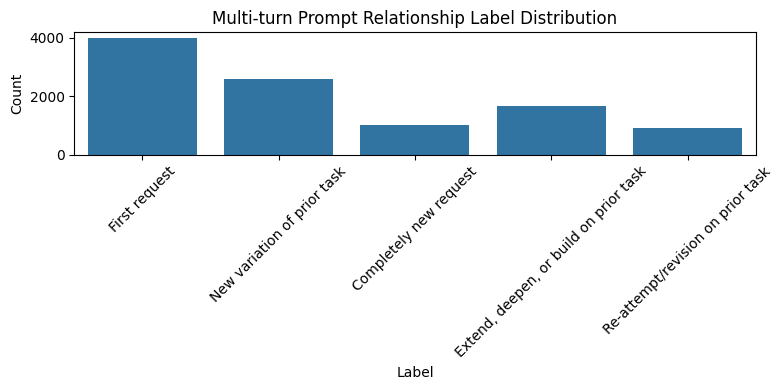

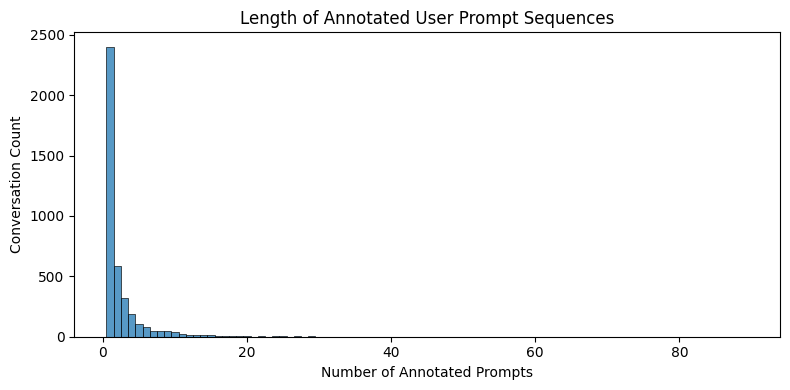

In [8]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Normalize .value if it's a single-item list
annotation_key = "automatic_v0-prompt_multi_turn_relationship"

for conv in dataset.data:
    for msg in conv.conversation:
        if msg.role == "user" and annotation_key in msg.metadata:
            val = msg.metadata[annotation_key].value
            # Unwrap single-element lists
            if isinstance(val, list) and len(val) == 1:
                msg.metadata[annotation_key].value = val[0]

# Extract multi-turn flows from user turns
multi_turn_flows = []

for conv in dataset.data:
    flow = []
    for msg in conv.conversation:
        if msg.role == "user" and annotation_key in msg.metadata:
            label = msg.metadata[annotation_key].value
            flow.append(label)
    if flow:
        multi_turn_flows.append(flow)

# Label frequency distribution
label_counts = Counter(label for flow in multi_turn_flows for label in flow)

# Sequence length distribution
flow_lengths = [len(flow) for flow in multi_turn_flows]



# Plot label distribution
plt.figure(figsize=(8, 4))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()))
plt.title("Multi-turn Prompt Relationship Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Plot flow length distribution
plt.figure(figsize=(8, 4))
sns.histplot(flow_lengths, bins=range(1, max(flow_lengths)+2), discrete=True)
plt.title("Length of Annotated User Prompt Sequences")
plt.xlabel("Number of Annotated Prompts")
plt.ylabel("Conversation Count")
plt.tight_layout()
plt.show()


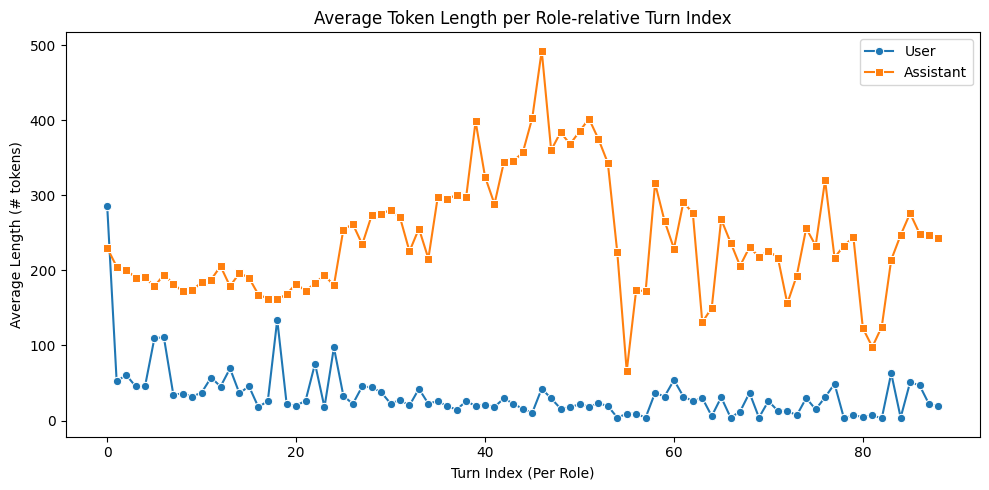

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Collect lengths of messages per turn index within each role
user_turn_lengths = defaultdict(list)
assistant_turn_lengths = defaultdict(list)

for conv in dataset.data:
    user_idx = 0
    assistant_idx = 0
    for msg in conv.conversation:
        length = len(msg.content.split())
        if msg.role == "user":
            user_turn_lengths[user_idx].append(length)
            user_idx += 1
        elif msg.role == "assistant":
            assistant_turn_lengths[assistant_idx].append(length)
            assistant_idx += 1

# Compute average length
avg_user_len_by_index = {i: np.mean(vals) for i, vals in user_turn_lengths.items()}
avg_assistant_len_by_index = {i: np.mean(vals) for i, vals in assistant_turn_lengths.items()}

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x=list(avg_user_len_by_index.keys()), y=list(avg_user_len_by_index.values()), label="User", marker="o")
sns.lineplot(x=list(avg_assistant_len_by_index.keys()), y=list(avg_assistant_len_by_index.values()), label="Assistant", marker="s")
plt.title("Average Token Length per Role-relative Turn Index")
plt.xlabel("Turn Index (Per Role)")
plt.ylabel("Average Length (# tokens)")
plt.legend()
plt.tight_layout()
plt.show()


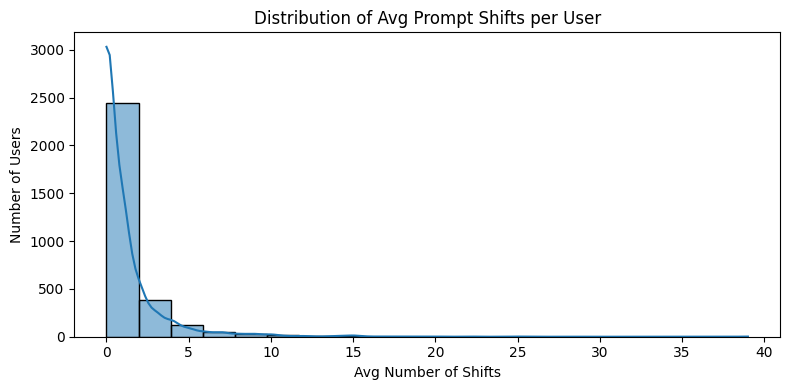

In [16]:
# Create DataFrame from summary (assumes you already created the `summary` dict)
import pandas as pd

summary_df = pd.DataFrame.from_dict(summary, orient='index')

# Plot: Histogram of average prompt shifts per user
plt.figure(figsize=(8, 4))
sns.histplot(summary_df["avg_shifts"], bins=20, kde=True)
plt.title("Distribution of Avg Prompt Shifts per User")
plt.xlabel("Avg Number of Shifts")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()


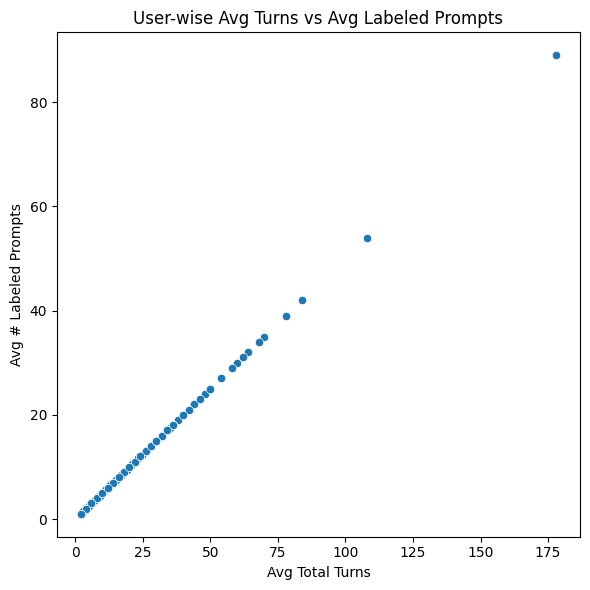

In [17]:
# Scatterplot of labeled prompts vs total turns per user
plt.figure(figsize=(6, 6))
sns.scatterplot(data=summary_df, x="avg_turns", y="avg_labeled")
plt.title("User-wise Avg Turns vs Avg Labeled Prompts")
plt.xlabel("Avg Total Turns")
plt.ylabel("Avg # Labeled Prompts")
plt.tight_layout()
plt.show()


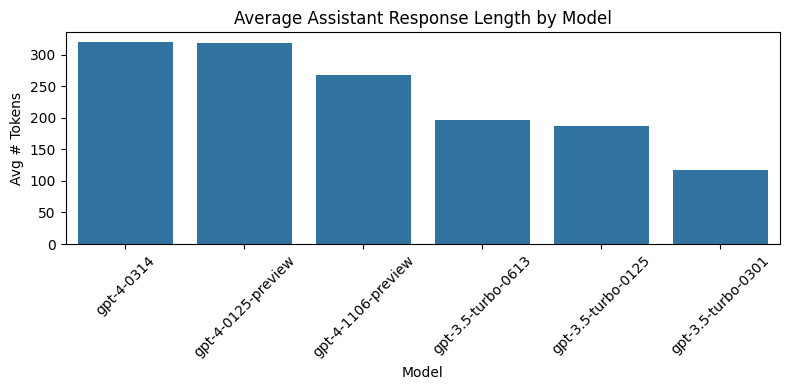

In [18]:

model_avg_df = pd.DataFrame.from_dict(model_avg_len, orient='index', columns=["avg_response_len"])
model_avg_df = model_avg_df.sort_values("avg_response_len", ascending=False)

# Plot
plt.figure(figsize=(8, 4))
sns.barplot(x=model_avg_df.index, y=model_avg_df["avg_response_len"])
plt.title("Average Assistant Response Length by Model")
plt.xlabel("Model")
plt.ylabel("Avg # Tokens")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [68]:
from collections import defaultdict, Counter
import pandas as pd

annotation_key = "automatic_v0-prompt_multi_turn_relationship"

# Step 1: Collect conversation-level stats per user
user_conversations = defaultdict(list)

for conv in dataset.data:
    user_id = conv.user_id
    prompt_labels = []

    for msg in conv.conversation:
        if msg.role == "user" and annotation_key in msg.metadata:
            label = msg.metadata[annotation_key].value
            if isinstance(label, list) and len(label) == 1:
                label = label[0]
            prompt_labels.append(label)

    if not prompt_labels:
        continue

    num_shifts = sum(1 for a, b in zip(prompt_labels, prompt_labels[1:]) if a != b)
    label_dist = Counter(prompt_labels)

    user_conversations[user_id].append({
        "num_turns": len(conv.conversation),
        "num_prompts": len(prompt_labels),
        "num_shifts": num_shifts,
        "label_counts": label_dist,
    })

# Step 2: Aggregate stats per user
user_stats = []

for user_id, conversations in user_conversations.items():
    all_turns = [c["num_turns"] for c in conversations]
    all_prompts = [c["num_prompts"] for c in conversations]
    all_shifts = [c["num_shifts"] for c in conversations]

    total_label_counts = Counter()
    for c in conversations:
        total_label_counts.update(c["label_counts"])

    total_prompts = sum(all_prompts)
    label_dist_pct = {f"label_{k}": v / total_prompts for k, v in total_label_counts.items()}

    user_stats.append({
        "user_id": user_id,
        "num_conversations": len(conversations),
        "avg_turns_per_conversation": sum(all_turns) / len(all_turns),
        "avg_annotated_prompts": sum(all_prompts) / len(all_prompts),
        "avg_topic_shifts": sum(all_shifts) / len(all_shifts),
        **label_dist_pct
    })

# Step 3: Convert to DataFrame
user_df = pd.DataFrame(user_stats)
user_df = user_df.sort_values(by="num_conversations", ascending=False)

# Display preview
print(user_df.head(10))


                                                user_id  num_conversations  \
627   3e7ae36b9ca739b0e16876727814a0e8470c8496aab833...                 43   
1937  2eef7d0f0b5b3cdd22f40849eefe0f13b05730cffa5bfd...                 34   
331   2a28eab6a25a22abbe8a2de22f61e06101936bad97e1b8...                 29   
1471  25fe0280393351ba0fcf578cad274f8f2ca29975caa299...                 27   
532   a89177c80571053584234edca85f348690bf0ab5873876...                 22   
724   a5146fac10d0a974d79af83042eed65659396495d29396...                 21   
767   dec1f72ae4d94e369602348fc957b0d6781051aa664f24...                 21   
2173  192327bac2b4988deb5bd3f7436a5413db8e42097f190b...                 20   
1456  cbbbb1787dc8a36e05d2acfc474c9fcb32c21927dd8982...                 17   
1954  3618f332f87a28193510ac02748f7ebe6a7ece470493b1...                 16   

      avg_turns_per_conversation  avg_annotated_prompts  avg_topic_shifts  \
627                     2.604651               1.302326         

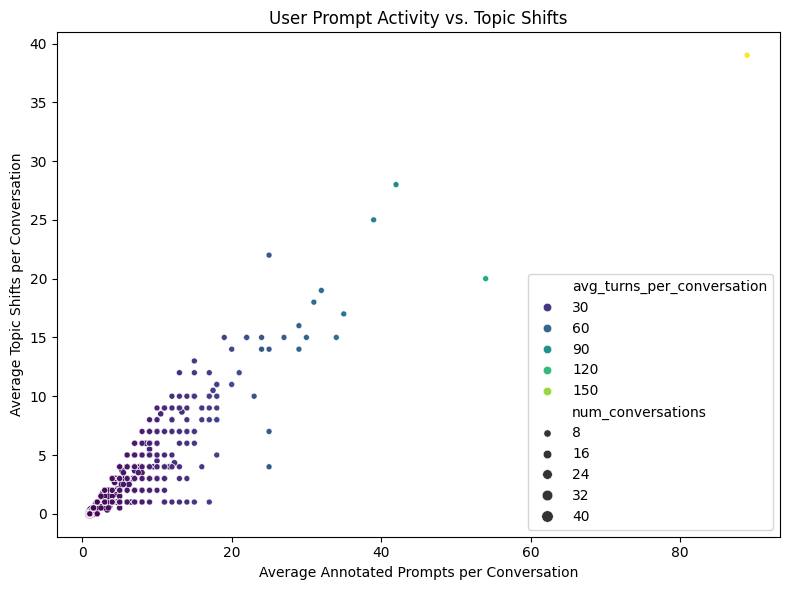

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=user_df,
    x="avg_annotated_prompts",
    y="avg_topic_shifts",
    size="num_conversations",
    hue="avg_turns_per_conversation",
    palette="viridis",
    legend="brief"
)
plt.title("User Prompt Activity vs. Topic Shifts")
plt.xlabel("Average Annotated Prompts per Conversation")
plt.ylabel("Average Topic Shifts per Conversation")
plt.tight_layout()
plt.show()


In [72]:
from collections import defaultdict, Counter
import pandas as pd
import numpy as np

annotation_key = "automatic_v0-prompt_multi_turn_relationship"

# Step 1: Collect stats per model
model_stats = defaultdict(list)

for conv in dataset.data:
    model = conv.model
    prompt_labels = []
    assistant_lengths = []

    for msg in conv.conversation:
        if msg.role == "user" and annotation_key in msg.metadata:
            label = msg.metadata[annotation_key].value
            if isinstance(label, list) and len(label) == 1:
                label = label[0]
            prompt_labels.append(label)

        elif msg.role == "assistant":
            assistant_lengths.append(len(msg.content.split()))

    if not prompt_labels:
        continue

    num_shifts = sum(1 for a, b in zip(prompt_labels, prompt_labels[1:]) if a != b)
    label_dist = Counter(prompt_labels)

    model_stats[model].append({
        "num_turns": len(conv.conversation),
        "avg_assistant_len": np.mean(assistant_lengths) if assistant_lengths else 0,
        "num_prompts": len(prompt_labels),
        "num_shifts": num_shifts,
        "label_counts": label_dist
    })

# Step 2: Aggregate per-model
records = []

for model, convs in model_stats.items():
    turns = [c["num_turns"] for c in convs]
    lengths = [c["avg_assistant_len"] for c in convs]
    prompts = [c["num_prompts"] for c in convs]
    shifts = [c["num_shifts"] for c in convs]

    label_totals = Counter()
    for c in convs:
        label_totals.update(c["label_counts"])

    total_prompts = sum(prompts)
    label_dist_pct = {f"label_{k}": v / total_prompts for k, v in label_totals.items()}

    records.append({
        "model": model,
        "num_conversations": len(convs),
        "avg_turns": np.mean(turns),
        "avg_assistant_length": np.mean(lengths),
        "avg_annotated_prompts": np.mean(prompts),
        "avg_topic_shifts": np.mean(shifts),
        **label_dist_pct
    })

# Step 3: Create DataFrame
model_df = pd.DataFrame(records).sort_values("num_conversations", ascending=False)

# Preview
print(model_df.head())


                model  num_conversations  avg_turns  avg_assistant_length  \
2  gpt-3.5-turbo-0613               1862   4.111708            233.119710   
0  gpt-3.5-turbo-0301                703   6.716927            137.643938   
3  gpt-4-1106-preview                631   6.494453            287.703566   
5  gpt-4-0125-preview                310   6.664516            320.773520   
4  gpt-3.5-turbo-0125                298   3.422819            214.490155   

   avg_annotated_prompts  avg_topic_shifts  label_First request  \
2               2.055854          0.699785             0.486155   
0               3.358464          1.486486             0.298602   
3               3.247227          1.364501             0.306491   
5               3.332258          1.341935             0.299129   
4               1.711409          0.533557             0.580392   

   label_New variation of prior task  label_Completely new request  \
2                           0.236416                      0.0773

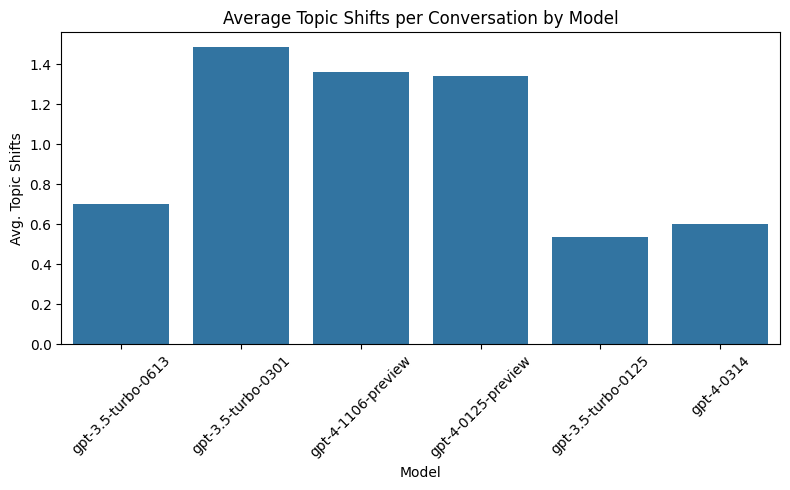

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(
    data=model_df,
    x="model",
    y="avg_topic_shifts"
)
plt.title("Average Topic Shifts per Conversation by Model")
plt.ylabel("Avg. Topic Shifts")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


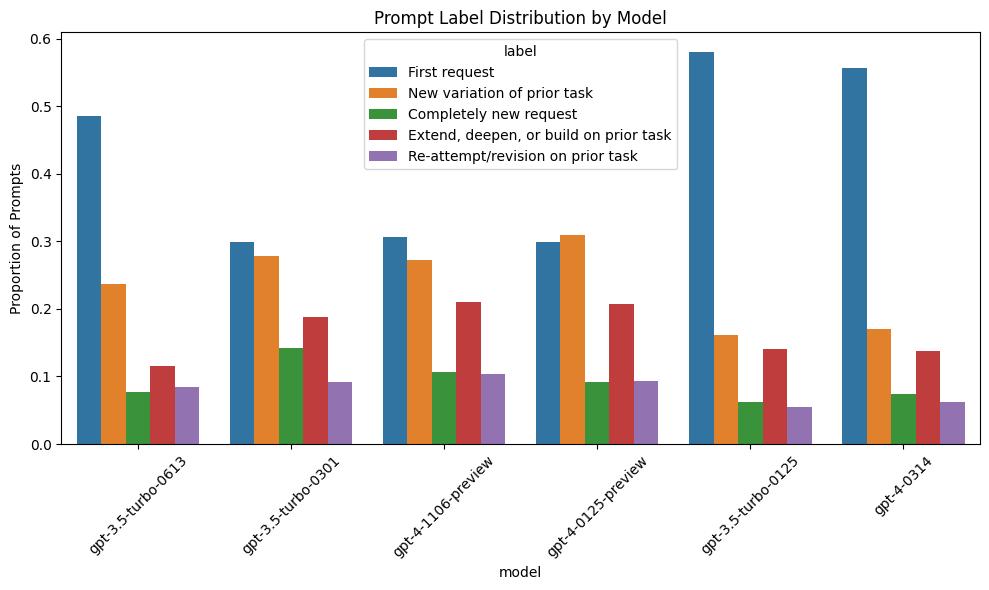

In [74]:
label_cols = [col for col in model_df.columns if col.startswith("label_")]
melted = model_df[["model"] + label_cols].melt(id_vars="model", var_name="label", value_name="proportion")
melted["label"] = melted["label"].str.replace("label_", "")

plt.figure(figsize=(10, 6))
sns.barplot(
    data=melted,
    x="model",
    y="proportion",
    hue="label"
)
plt.title("Prompt Label Distribution by Model")
plt.ylabel("Proportion of Prompts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


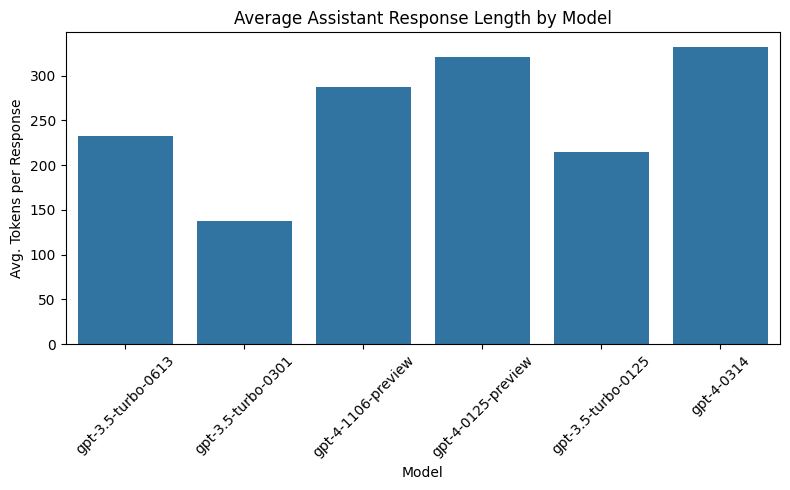

In [75]:
plt.figure(figsize=(8, 5))
sns.barplot(
    data=model_df,
    x="model",
    y="avg_assistant_length"
)
plt.title("Average Assistant Response Length by Model")
plt.ylabel("Avg. Tokens per Response")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [24]:
from collections import defaultdict, Counter
import pandas as pd
import numpy as np

annotation_key = "automatic_v0-prompt_multi_turn_relationship"
records = []

# Loop through each conversation
for conv in dataset.data:
    model = conv.model
    user_turns = []
    assistant_turns = []

    for msg in conv.conversation:
        if msg.role == "user" and annotation_key in msg.metadata:
            label = msg.metadata[annotation_key].value
            if isinstance(label, list) and len(label) == 1:
                label = label[0]
            user_turns.append(label)

        elif msg.role == "assistant":
            assistant_turns.append(len(msg.content.split()))

    # Align user labels and assistant responses by index
    for i in range(min(len(user_turns), len(assistant_turns))):
        records.append({
            "model": model,
            "turn_index": i * 2,  # Because user turns are even (0,2,...)
            "prompt_label": user_turns[i],
            "response_length": assistant_turns[i]
        })

# Convert to DataFrame
pairwise_df = pd.DataFrame(records)


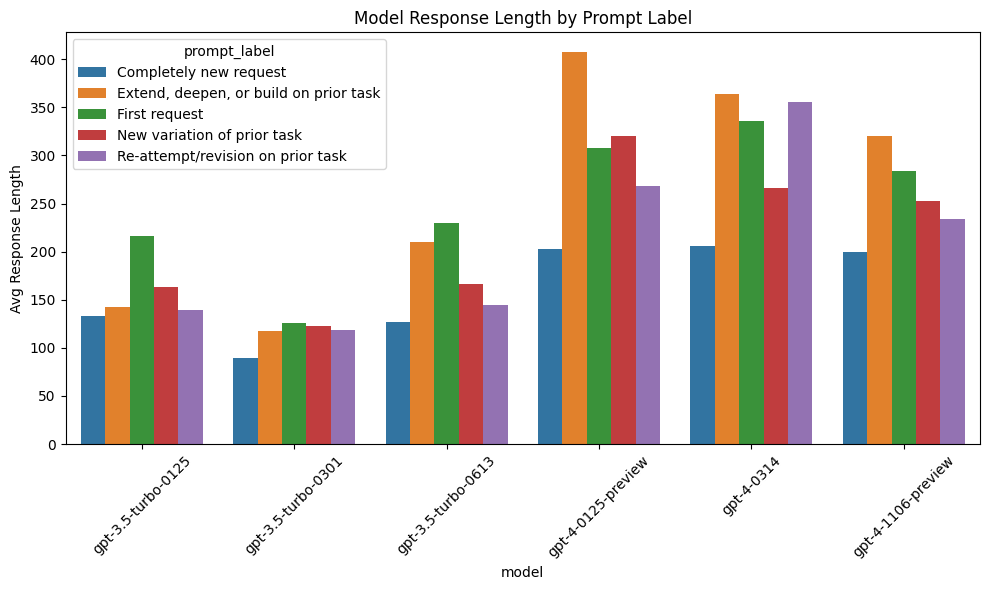

In [29]:
grouped = pairwise_df.groupby(["model", "prompt_label"])["response_length"].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=grouped, x="model", y="response_length", hue="prompt_label")
plt.title("Model Response Length by Prompt Label")
plt.ylabel("Avg Response Length")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [76]:
from collections import defaultdict, Counter
import pandas as pd

annotation_key = "automatic_v0-prompt_multi_turn_relationship"
position_counts = defaultdict(Counter)

for conv in dataset.data:
    labeled = []
    for msg in conv.conversation:
        if msg.role == "user" and annotation_key in msg.metadata:
            val = msg.metadata[annotation_key].value
            if isinstance(val, list) and len(val) == 1:
                val = val[0]
            labeled.append(val)

    for i, label in enumerate(labeled):
        position_counts[i][label] += 1

# Normalize to proportions
max_turn = max(position_counts.keys())
rows = []

for i in range(max_turn + 1):
    total = sum(position_counts[i].values())
    for label, count in position_counts[i].items():
        rows.append({
            "turn_index": i,
            "label": label,
            "proportion": count / total
        })

turn_df = pd.DataFrame(rows)


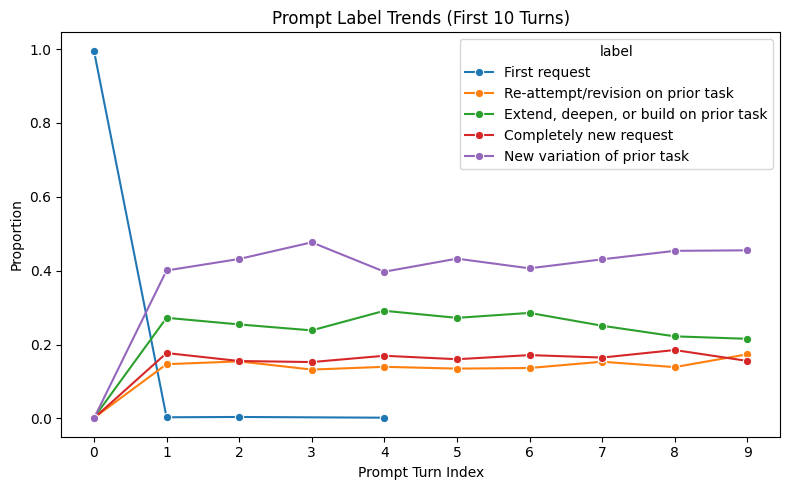

In [83]:
turn_cutoff = 10
filtered_df = turn_df[turn_df["turn_index"] < turn_cutoff]

plt.figure(figsize=(8, 5))
sns.lineplot(
    data=filtered_df,
    x="turn_index",
    y="proportion",
    hue="label",
    marker="o"
)
plt.title("Prompt Label Trends (First 10 Turns)")
plt.xlabel("Prompt Turn Index")
plt.ylabel("Proportion")
plt.xticks(range(turn_cutoff))
plt.tight_layout()
plt.show()


In [84]:
from collections import defaultdict, Counter

annotation_key = "automatic_v0-prompt_multi_turn_relationship"
turn_label_by_model = defaultdict(lambda: defaultdict(Counter))

# Collect prompt labels by turn index, per model
for conv in dataset.data:
    model = conv.model
    labeled = []
    for msg in conv.conversation:
        if msg.role == "user" and annotation_key in msg.metadata:
            val = msg.metadata[annotation_key].value
            if isinstance(val, list) and len(val) == 1:
                val = val[0]
            labeled.append(val)

    for i, label in enumerate(labeled):
        turn_label_by_model[model][i][label] += 1

# Convert to long-format dataframe
rows = []
for model, position_dict in turn_label_by_model.items():
    for i, label_counter in position_dict.items():
        total = sum(label_counter.values())
        for label, count in label_counter.items():
            rows.append({
                "model": model,
                "turn_index": i,
                "label": label,
                "proportion": count / total
            })

model_turn_df = pd.DataFrame(rows)


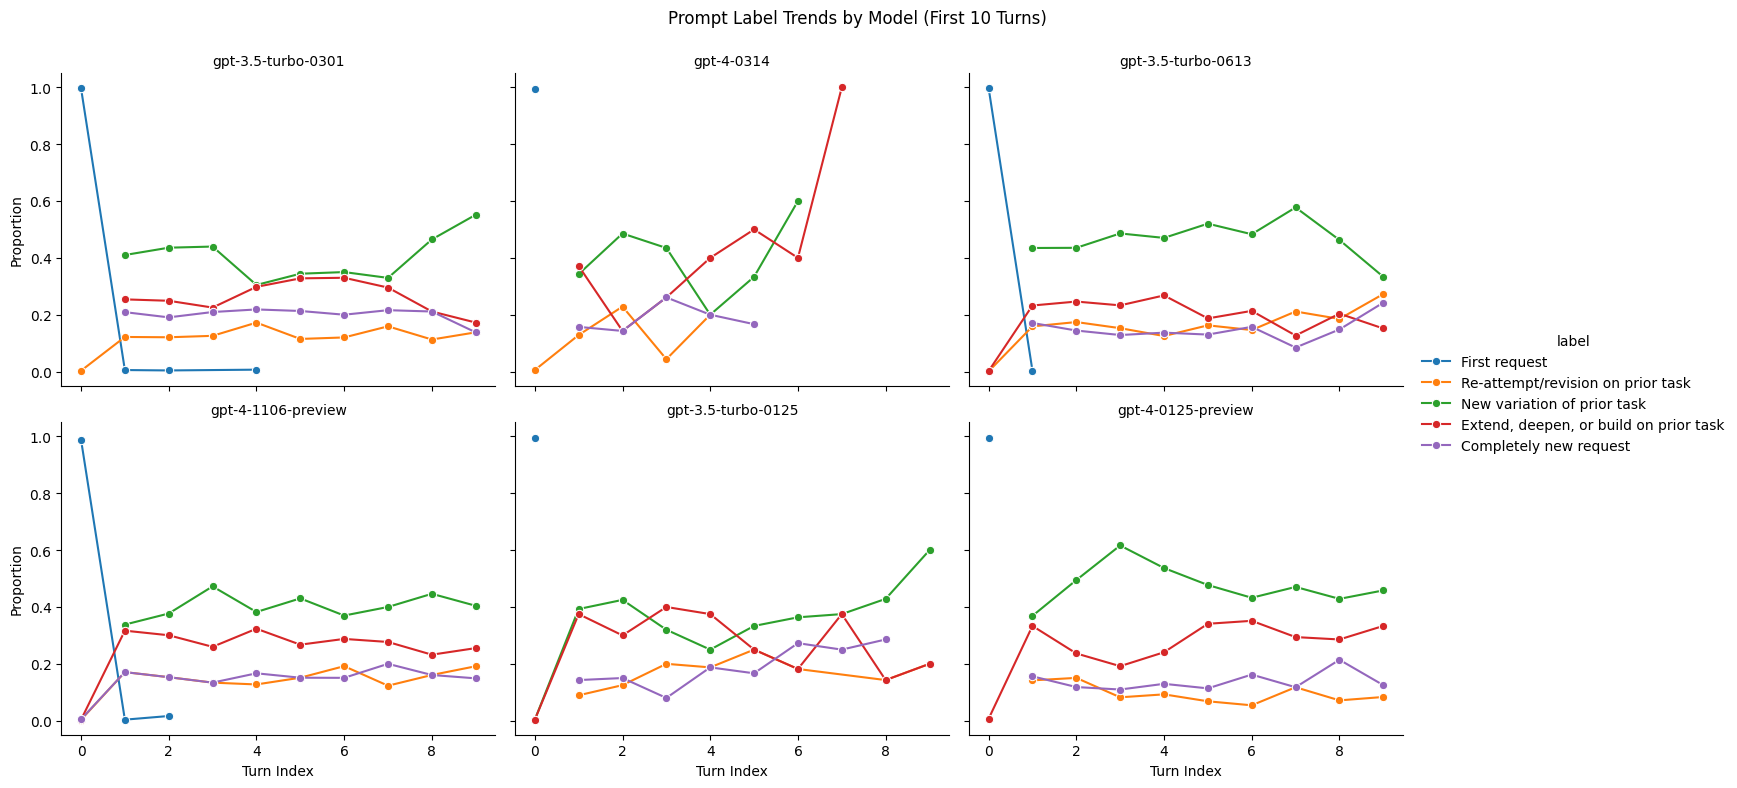

In [86]:
# Limit to first 10 turns for clarity
cutoff = 10
filtered = model_turn_df[model_turn_df["turn_index"] < cutoff]

g = sns.FacetGrid(
    data=filtered,
    col="model",
    hue="label",
    height=4,
    aspect=1.2,
    col_wrap=3,
    sharey=True
)
g.map_dataframe(
    sns.lineplot,
    x="turn_index",
    y="proportion",
    marker="o"
)
g.add_legend()
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Turn Index", "Proportion")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Prompt Label Trends by Model (First 10 Turns)")
plt.show()


In [27]:
from collections import Counter

even_transitions = Counter()

for conv in dataset.data:
    labels = []
    for msg in conv.conversation:
        if msg.role == "user" and annotation_key in msg.metadata:
            val = msg.metadata[annotation_key].value
            if isinstance(val, list) and len(val) == 1:
                val = val[0]
            labels.append(val)

    # Extract 0→2, 2→4...
    for i in range(0, len(labels) - 2, 2):
        src = labels[i]
        tgt = labels[i + 2]
        even_transitions[(src, tgt)] += 1


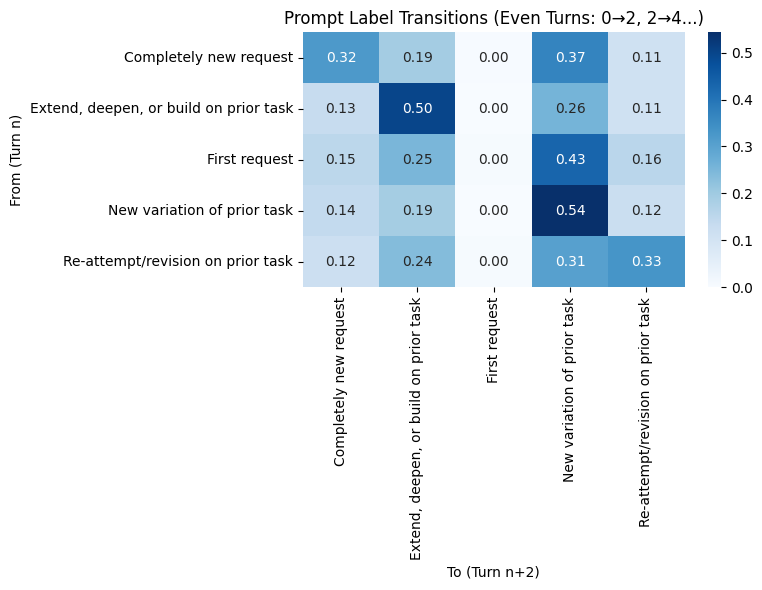

In [28]:


# Build label set
all_labels = sorted(set(src for src, _ in even_transitions) | set(tgt for _, tgt in even_transitions))
matrix = pd.DataFrame(0, index=all_labels, columns=all_labels)

# Fill in matrix
for (src, tgt), count in even_transitions.items():
    matrix.loc[src, tgt] += count

# Normalize by rows
matrix = matrix.div(matrix.sum(axis=1), axis=0).fillna(0)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, cmap="Blues", fmt=".2f")
plt.title("Prompt Label Transitions (Even Turns: 0→2, 2→4...)")
plt.xlabel("To (Turn n+2)")
plt.ylabel("From (Turn n)")
plt.tight_layout()
plt.show()
 